# Introduction

A sound machine learning framework needs to answer business objectives as defined by the business under constraints such as scalibility, availability(or scarcity) of quality training data etc. General Characteristic of good machine learning model are:
1.	Approximates the training data as closely as possible.
2.	Generalizable for unseen future data (Avoids overfitting). 
3.	Has good runtime performance i.e. it takes less time to run inference and occupies small disk size 
    4.	The aim of modeling exercise. If the sole objective of model building is to predict the output where machine learning model act as black box, then we try to fit a model which gives the best possible performance on test data under given cost constraints. However, if the objective of model building is not just predicting the outcome but also interpretability and determining which features have an impact on the output, then we select model which is interpretable and less complex. Apart from model selection, appropriate choice of loss function is also important.

Selecting the right machine learning algorithm is the most important step of model design but there are other important step as well. Model Design would include

1. Data Exploration
2. Cleaning of data 
3. Feature engineering (includes feature processing and creating hand generated features based on domain knowlegde and data insight obtained from Data exploration
4. Selecting the machine learning algorithm
5. Selecting the loss function and evaluation metric
6. Hyparameter finetuning

Feature engineering step depends also on the machine learning algorithm selected for e.g. Decision tree based model such as Random forest are robust to variation in ranges of values different features take, so no rescaling is required if we mix of categorical and numerical variables, whereas SVM,logisitic regression would require normaliztion of all the features.

There are constraints while design the machine learning framework. There are time constraints (solution must be delivered in quick time as per business demands). There are constraints on cost and infrastructure and talent (model takes huge space or inference time is large). In such scenarios, Simple Modeling approach is selected over better performing but complex approach. Along the time, model could be trained on more data, more complex feature engineering and more sophisticated machine learning algorithm  could be used and it could replace the current model 

# Data Cleansing and Feature Engineering
From the exploratory data analysis, we found that the output variable logistics_dropoff_distance has more than 99% values below 1000 but has outliers with values more than 15 million. As such a large distance is implausible we delete all the rows with values of drop off distance more than 1000. Since we have 2.5 million data points, deleting a small percentage will not be a problem. 

Apart from that the features are mix of categorical and numerical variables. We have date column but plotting the daily mean values of the drop off distance we see that values are almost constant with slight random variation. However, we did observe hourly cycle of drop off distance and slight variation the day of the week. We generate these two features from the date column. The original date column is not considered

The geohash code at precision level 8 has too many categories which is problematic as it leads to very dimensional sparse feature space. Therefore we use geohash precision level 5 code by extracting the first 5 chars of the geohash precision 8 code. The pincode column has too many categories and the data is spread along each of them and it has around 9% of the values missing. So we will not be considering these columns.  

Other thing we notice was the presence of outliers in numerical variables and variables having values in different ranges i.e. variability of scale.

Apart from this, we one hot encode the categroical variables. Although, the random forest regressor model, which is the alogrithm selected for this exercise, does not require to do one hot encoding, but to see which class of the categoircial variable is having an impact, we one hot encode the categorical features. We consider boolean variables as numerical variable for this exercise.

In this execrise we only have chosen only one model architecture i.e. Random forest which takes into non linear relationship between predictors and target variable. However, for models like Linear Regression, Support Vector Regression (with no kernel transformation) the relationship being modelled is essentially linear and to take into non linearity we use Nystroem kernel approximation. We will take about this more in the Training Framework section.  

# Machine Learning Model selection
We choose Random Forest regression 

1. Random Forest naturally does feature selection as the decision trees partitioning tries to minimize the error/impurity of the node. Nodes with the greatest decrease in impurity happen at the start of the trees, while nodes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features. Random Forest has been used in many cases for selecting features. This is the most important reason we are selecting Random forest as one of the goals of this exercise is to give feed back for Front End improvements which could reduce the logistic drop off distance 
2. Random Forest is inherently robust to overfitting as it fits a large number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.
3. Random forest also captures non-linear relationship between output and 
4. The number of trees can be increased till the model stops overfittings and generalizes pretty well to unseen data. Nowadays, fitting large number of trees is not computationally expensive because of easy accessibility parallel computing. In fact, since random forest can fit trees in a parallel manner, training time required for Random forest is very low on new system with multi core cpus. As a result, Random forest easily scales to dataset having large number of rows or if there are moderately large number of columns.
5. Random forest can handle variables of different scales as it's based on tree partitioning algorithm which is immune to the absolute value of the variable. Only ranking of values matters. Although for the current sample data, every variable lies within the same range, the future data can have variables which have different range of values 
6. Random forest also handles outliers well because each tree is build on random subset of data. Correlation between output variable is also well handled because for each split we randomly select only subset of variables.

Loss function is what guides our model training. The output variable even after removing has outliers and the distribution of output variable is skewed. To ensure that model is not not overtly sensitive to large output values we use mean absolute error criteria for splitting of nodes. 

# Accuracy Metric 
Choosing the right performance is very critical for selecting the best model. If the performance metric does not reflect the actual business need, we might up with suboptimal model (suboptimal in terms of the model algorithm and hyper-parameters.). As our output label could take large range of values, we use logarithmic mean squared error as the accuracy metric. Lograithmic mean squared error is the mean over the seen data of the squared differences between the log-transformed true and predicted values. Consider one example where ground truth value of logistics dropoff distance is 10 but model predicts 20 (100) and another example where ground truth value of logistics dropoof distance is 1000 but our model predicts 990. In both cases absolute error is same but predicting 20 for ground truth value of 10 is much severe as compared to predicting 990 for gt value of 1000. Here we don’t want large errors to be significantly more penalized than small ones, since the range of the target value is large. The introduction of the logarithm makes MSLE only care about the relative difference between the real and the predicted value, or in other words, it only cares about the porcentual difference between them. This means that MSLE will treat small differences between small true and predicted values approximately the same as big differences between large true and predicted values.
 

# Training Framework
We use scikit learn library for this exercise, where we define attributes and methods to encapsulate the entire end to training and inference process, right from data preprocessing, feature engineering and model fitting and model prediction, saving and loading of trained models. The BaseModel class takes the following attributes:

1. model_type: sklearn model type or None
2. high_prec_geohash_col: name of column with geohash code
3. date_col: name of date column
4. categorical_vars list of categorical variables
5. numerical_vars list of numerical variables
6. output_col: name of the output variable
7. low_precision_level: lower precision level for geo code
8. do_kernel_transform: Boolean variable whether to do Kernel approximation of features
9. do_normalise_col: Boolean variable whether to scale column or not. (True scale feature using Robust scaler from sklearn. if False no sclaing is done

Additional keyword arguments could also be passed. The BaseModel class has *best_model* attribute which is essentially sklearn pipeline including feature processing and model. Depending on the alogorithm you choose, the feature processing steps could be customised. This Class can also be used for Classification kind of problems.

### Nystroem Approximation
The feature engineering pipeline defined in the BaseModel class has last step of Nystroem transformation if the do_kernel_transform attribute is True. 

Models like Support Vector regression, Linear Regression assume linearity between ouptut and input variables which is seldom the case. Using non-linear kernel transformation for Support Vector Regression is computationally very expensive if the data set is large. To take into account non-linearity without spending too much time on computation, we use Kernel approximation technique Nystroem to construct an approximate feature map for user defined kernel using a subset of the data as basis. The Nystroem method is a general method for low-rank approximations of kernels. It achieves this by essentially subsampling the data on which the kernel is evaluated. By default Nystroem uses the rbf kernel, but it can use any kernel function or a precomputed kernel matrix. The number of samples used is also the dimensionality of the resulting feature map. The main disadvantage here is we loose on explainability of the model. 


# Model training

In [1]:
# importing required packages and python modules
from model.model import * 
import configparser
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import json

In [2]:
# Parsing the config file to get model specs 
cfgParse = configparser.ConfigParser()
cfgParse.read("input.cfg")
loc_file_path = str(cfgParse.get("input", "train_data"))

output_col = str(cfgParse.get("model_specs", "output_col"))
high_geohash_precision = cfgParse.get("model_specs", "high_geohash_precision_table")
date_col = cfgParse.get("model_specs", "date_col")
categorical_vars = [col for col in cfgParse.get("model_specs", "categorical_vars").split(",")]
numerical_vars = [col for col in cfgParse.get("model_specs", "numerical_vars").split(",")]

model_loc_folder = str(cfgParse.get("model", "dir"))

In [3]:
#Reading the input data as pandas data frame
# reading the json file
with open(loc_file_path, 'r') as filein:   
    location_df = pd.DataFrame.from_dict(json.load(filein))

# Removing rows having logistic distance greater than 1000
location_df = location_df[location_df[output_col]<1000]

In [4]:
# splitting the data into train and test
train_data, test_data  = train_test_split(location_df, test_size=0.2, random_state=100)
# del the location dataframe as it is no longer required so as to free up RAM
del location_df

In [5]:
Random_Forest_Regressor = BaseModel(RandomForestRegressor(n_estimators=100, verbose = True, random_state = 123, max_depth = 8, n_jobs=5), high_geohash_precision, date_col, 
                             categorical_vars, numerical_vars, output_col)

In [7]:
Random_Forest_Regressor.fit(train_data, test_data, hyperparameter_dict={'max_depth': (6,8,10)}, evaluation_metric = 'neg_mean_squared_log_error') 

Randomized search for optimal hyper parameters
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/Huzefa.Calcuttawala/miniconda/envs/location/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
/Users/Huzefa.Calcuttawala/miniconda/envs/location/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeou

[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   6.7s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total=  42.7s
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 1.0min
[Pipeline] ............... (step 2 of 2) Processing reg, total=98.9min


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 308.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 158.3min


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  10.9s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 1.0min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 1.4min
[Pipeline] .............. (step 2 of 2) Processing reg, total=103.5min


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 538.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 540.1min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 540.7min finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  13.3s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 1.3min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 1.8min
[Pipeline] .............. (step 2 of 2) Processing reg, total=133.3min


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.9s finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   8.8s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 1.9min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 2.8min
[Pipeline] .............. (step 2 of 2) Processing reg, total=135.3min


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 569.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.4s finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  14.7s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 1.5min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 2.0min
[Pipeline] .............. (step 2 of 2) Processing reg, total=134.4min


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 343.4min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 429.1min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    5.2s finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  11.2s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 1.7min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 2.4min
[Pipeline] .............. (step 2 of 2) Processing reg, total=133.8min


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 332.5min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 313.2min


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  31.0s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 2.4min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 3.9min
[Pipeline] .............. (step 2 of 2) Processing reg, total=129.6min


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 559.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 553.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.0s finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  36.2s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 2.7min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 5.0min
[Pipeline] .............. (step 2 of 2) Processing reg, total=130.6min
[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  31.9s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 2.7min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 4.3min
[Pipeline] .............. (step 2 of 2) Processing reg, total=136.2min


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 603.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 536.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 515.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   1.2s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total=   5.7s
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total=   9.4s


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   1.2s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total=   8.2s
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total=  11.4s
[Pipeline] ............... (step 2 of 2) Processing reg, total=89.9min
[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  33.5s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total= 2.6min
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing reg, total=82.8min
[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   1.4s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total=  16.9s
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total=  22.7s
[Pipeline] ............... (step 2 of 2) Processing reg, total=94.6min
[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=  34.5s
[ColumnTransformer]  (2 of 2) Processing imput

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 30.5min finished


[Pipeline] ............... (step 2 of 2) Processing reg, total=17.4min


In [9]:
# Summary of the cross validation fit
pd.DataFrame.from_dict(Random_Forest_Regressor.cross_val_result_summary)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15303.285533,1665.068487,406.981847,715.942977,6,{'reg__max_depth': 6},-0.907886,-0.909765,-0.909923,-0.908708,-0.909610,-0.909178,0.000772,3
1,31609.267675,2857.462704,36.019475,8.878889,8,{'reg__max_depth': 8},-0.907457,-0.909411,-0.909525,-0.908132,-0.909116,-0.908728,0.000803,2
2,34095.109735,1401.160734,9.997689,6.582247,10,{'reg__max_depth': 10},-0.907117,-0.909156,-0.909223,-0.907779,-0.908779,-0.908411,0.000827,1


Looking at the values of negative mean squared log error for all the three values of parameters, they are almost same. But surprisingly the scoring time for model with depth as 6 is highest. This is definitely due to some randomness of the cv split as indicated by large standard deviation for score time. Thus we choose the model with max depth 6 as the best model and refit the model with max_depth = 6

In [10]:
Random_Forest_Regressor_max_depth_6 = BaseModel(RandomForestRegressor(n_estimators=100, verbose = True, random_state = 123, max_depth = 6, n_jobs=5), high_geohash_precision, date_col, 
                             categorical_vars, numerical_vars, output_col)

In [11]:
Random_Forest_Regressor_max_depth_6.fit(train_data, test_data)

/Users/Huzefa.Calcuttawala/location/model/model.py:153: ModelTrainingWarning: No hyperparameters to train. fitting the model with default/pre-defined optimum values
  if not tuning_hyperparameters_dict:


[ColumnTransformer]  (1 of 2) Processing One_hot_encoder, total=   1.2s
[ColumnTransformer]  (2 of 2) Processing impute_num_var, total=   5.7s
[Pipeline]  (step 1 of 2) Processing feature_extraction_pipeline, total=   8.3s


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 11.6min finished


[Pipeline] ............... (step 2 of 2) Processing reg, total=11.6min
calculating test score


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.7s finished


-0.907722749653783


In [16]:
# Calculating the MAE of the trained model on test_data
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Calculating the predictive values
pred_distance = Random_Forest_Regressor_max_depth_6.predict(test_data.drop([output_col], axis='columns', inplace=False))
# Calculating mean absolute error
mae = mean_absolute_error(test_data[output_col], pred_distance)
print("The mean absolute error on the test data is %.2f" % mae)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s


The mean absolute error on the test data is 38.00


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.7s finished


Now, lets see which features are important for the detection. Since we have one hot encoding of categorical features, we need to get the names of the features generated by the One hot encoder because that's what is being fed to the regressor and not the categorical variables directly. So we first get the feature names from scikit learn model pipeline. Make sure the feature order is exactly the same as it goes the regressor. Referring to the model.py file first transformer of column transformer of feature extraction pipeline is one hot encoding and second is imputation of numerical variable. Then we get the feature importance. 

In [28]:
# Feature Importance
## getting the feature names being passed to the regressiion model
cat_feature_names = Random_Forest_Regressor_max_depth_6.best_model.named_steps['feature_extraction_pipeline'].named_transformers_.One_hot_encoder.get_feature_names()
final_feature_names = cat_feature_names.tolist() + numerical_vars
feature_importance = Random_Forest_Regressor_max_depth_6.best_model.named_steps['reg'].feature_importances_
zipped = zip(final_feature_names, feature_importance)
feat_imp_df = pd.DataFrame(zipped, columns=["feature", "feature_importance"])
# Sort the features by the absolute value of their coefficient
feat_imp_df["feature_importance"] = feat_imp_df["feature_importance"]*100
feat_imp_df = feat_imp_df.sort_values("feature_importance", ascending=False)

Text(0.5, 0, '% Features')

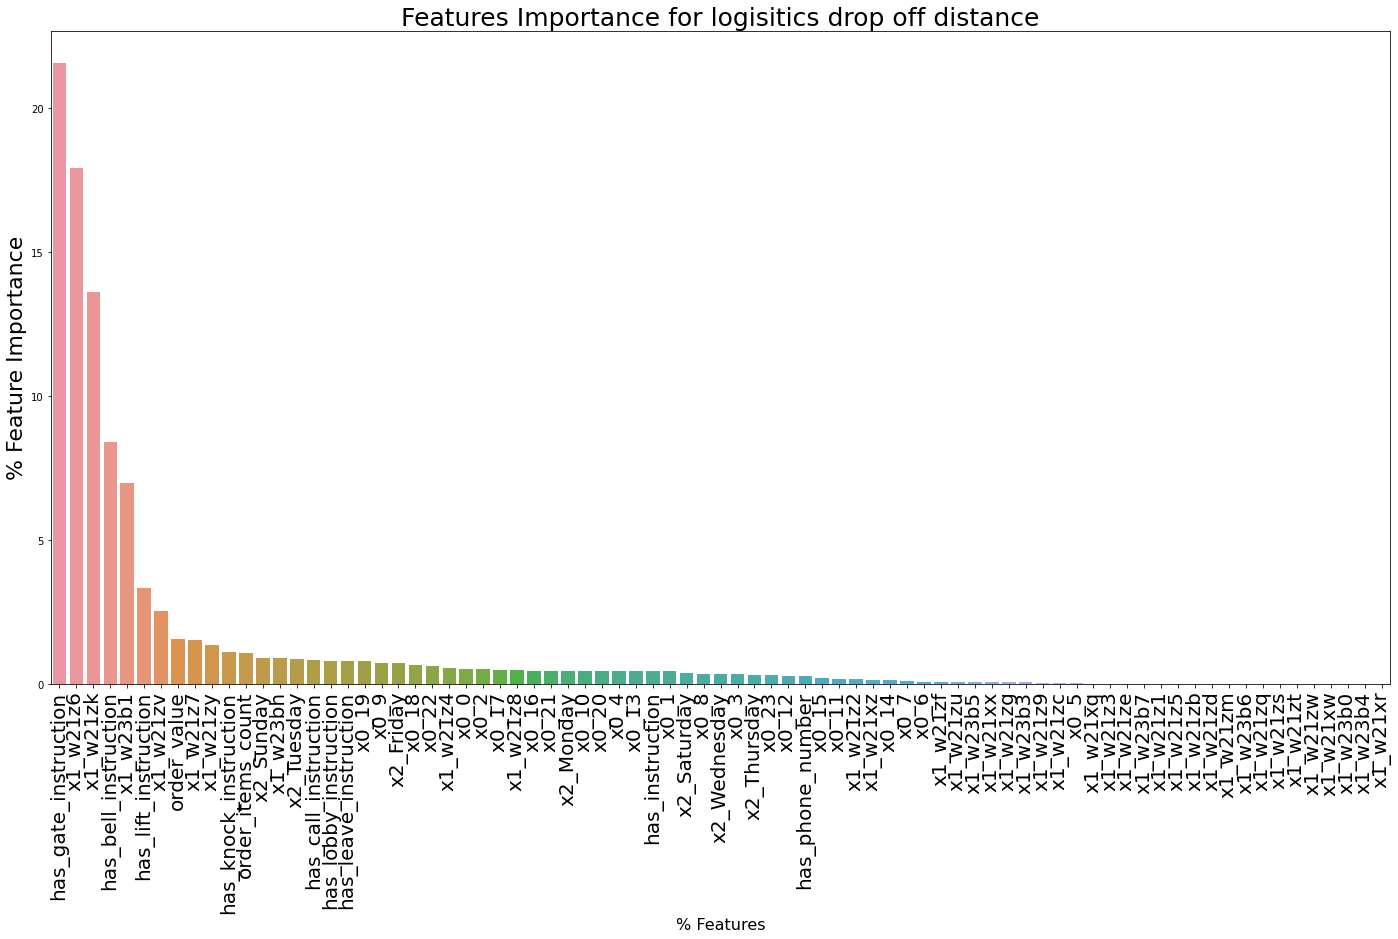

In [29]:
# plotting the feature importance
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
sns.barplot(x="feature",
            y="feature_importance",
            data=feat_imp_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Features Importance for logisitics drop off distance", fontsize=25)
ax.set_ylabel("% Feature Importance", fontsize=22)
ax.set_xlabel("% Features", fontsize=16)

Text(0.5, 0, '% Features')

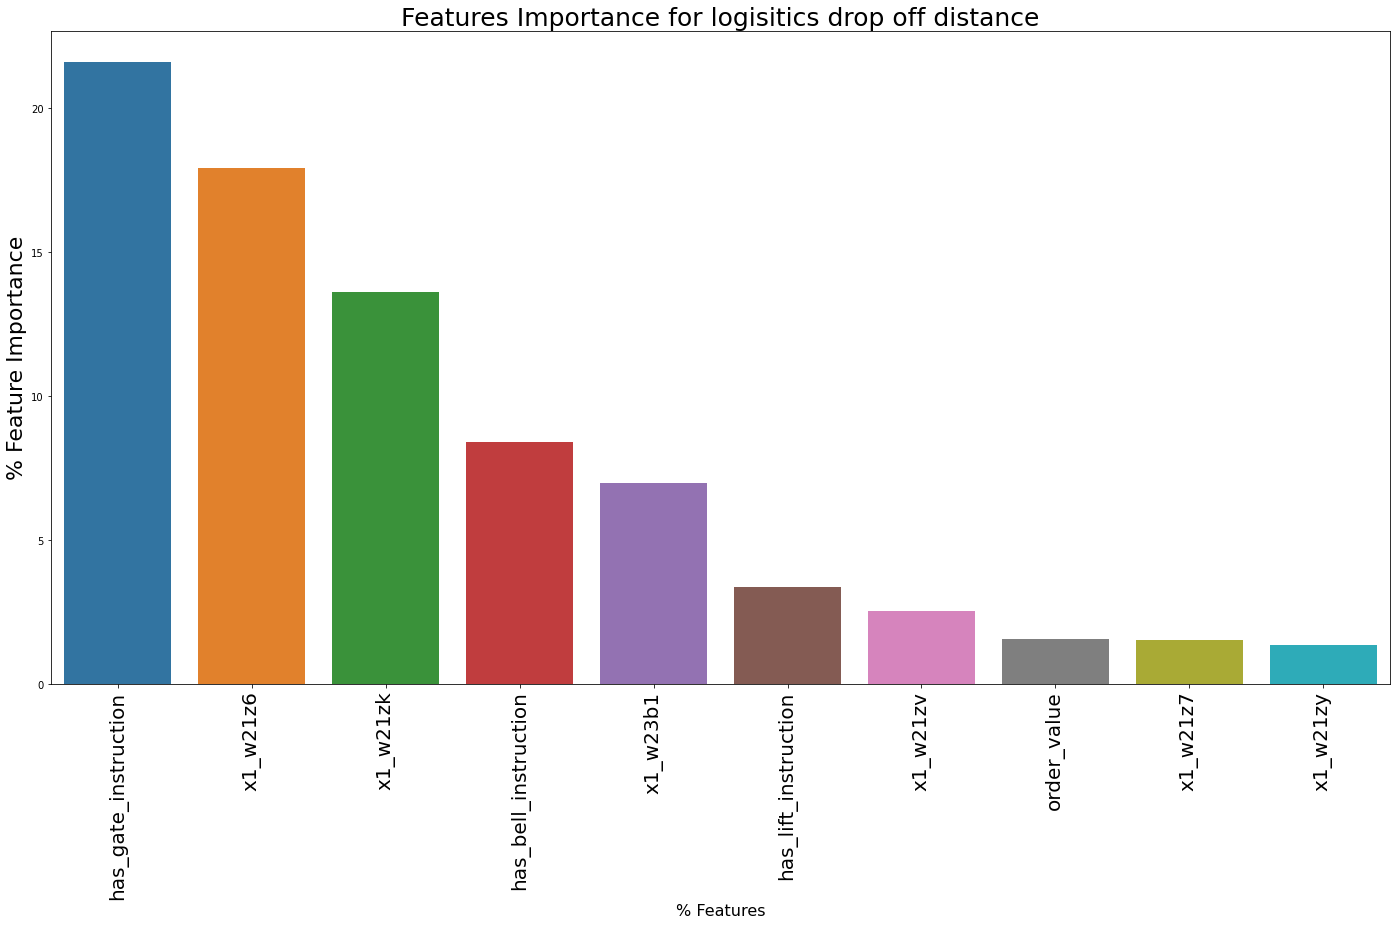

In [30]:
# plotting the feature importance for top 10 features
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
sns.barplot(x="feature",
            y="feature_importance",
            data=feat_imp_df.head(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Features Importance for logisitics drop off distance", fontsize=25)
ax.set_ylabel("% Feature Importance", fontsize=22)
ax.set_xlabel("% Features", fontsize=16)

Plotting the feature importance, we can see that having gate instrucions and bell instrucions (surprsing about bell instruction). Also the areas with geo hash code w21z6 seems to be important factor in deciding the drop off distance.

In [31]:
train_data['geo_precision5_code'] = train_data[high_geohash_precision].str[:5]
train_data[train_data['geo_precision5_code']=='w21z6'][output_col].describe()

count    179192.000000
mean         60.748852
std          81.983132
min           0.000000
25%          22.991910
50%          40.454399
75%          68.694243
max         999.968346
Name: logistics_dropoff_distance, dtype: float64

In [32]:
train_data[train_data['geo_precision5_code']!='w21z6'][output_col].describe()

count    1.881903e+06
mean     5.511022e+01
std      7.603395e+01
min      0.000000e+00
25%      2.144206e+01
50%      3.748996e+01
75%      6.242649e+01
max      9.999533e+02
Name: logistics_dropoff_distance, dtype: float64

The descriptive statistics show that for region w21z6 is slightly higher than the rest of the data but is not significantly higher.

In [33]:
train_data.groupby(['has_gate_instruction'])[output_col].describe()

,count,mean,std,min,25%,50%,75%,max
has_gate_instruction,,,,,,,,
False,1979238.0,55.734234,76.848441,0.000000,21.601091,37.786460,63.052801,999.968346
True,81857.0,52.365551,69.863310,0.025714,20.856169,36.401655,60.436055,996.968084


In [34]:
# saving the model architecture
Random_Forest_Regressor_max_depth_6.save_model(os.path.join(model_loc_folder, "randomforest100_max-depth-6_v0.pkl"))

Again there is no discernible difference between the True and False classes.

# Front End Suggestions
Based on the model training and data exploration these are the few suggested steps:
1. The customers seem to be not filling all the instructions. The UI design needs to be more customer friendly so that customers can easily fill the all the instructions especially the gate instructions and lobby instructions. 
2. The customers should have option to move the address pin to exact location of their delivery address. Specially for geohash codes such as w21xz where the dropoff distance are higher than other regions.


# Future Improvements
1. I would have considered hyperparameter tuning over large set of possible hyperparameter values.
2. Tried permutation based feature importance instead of relying on in built feature imporatnce given by Random Forest method. Permutation based feature importance is more accurate than impurity based feature importance given by tree based models.
3. Try different model such as Support Vector regression which is more accurate than random forest. We can select important features by fitting a random forest model follwed by permutation based feature selection and the use that important features only to train a different machine learning algorithm. We can than evaluate the performance of each of the ml algorithms on the test data and select the best one 
4. Instead of using mean logarithmic error, could have used mean absolute percentage error as it is more intuitive